# Project 1: Exploratory Data Analysis (EDA)

## Back Story

An email from a potential client:

> Cliff and Roberto -
>
> It was great to meet with you and chat at the event where we recently met and had a nice chat. We’d love to take some next steps to see if working together is something that would make sense for both parties.
>
> As we mentioned, we are interested in harnessing the power of data and analytics to optimize the effectiveness of our street team work, which is a significant portion of our fundraising efforts.
>
> WomenTechWomenYes (WTWY) has an annual gala at the beginning of the summer each year. As we are new and inclusive organization, we try to do double duty with the gala both to fill our event space with individuals passionate about increasing the participation of women in technology, and to concurrently build awareness and reach.
>
> To this end we place street teams at entrances to subway stations. The street teams collect email addresses and those who sign up are sent free tickets to our gala.
>
> Where we’d like to solicit your engagement is to use MTA subway data, which as I’m sure you know is available freely from the city, to help us optimize the placement of our street teams, such that we can gather the most signatures, ideally from those who will attend the gala and contribute to our cause.
>
> The ball is in your court now—do you think this is something that would be feasible for your group? From there we can explore what kind of an engagement would make sense for all of us.
>
> Best,
>
> Karrine and Dahlia
>
> WTWY International

### Data:

 * MTA Data (Google it!)
 * Additional data sources welcome!
  
### Skills:

 * `python` and `pandas`
 * visualizations via Matplotlib & seaborn

### Analysis:

 * Exploratory Data Analysis

### Deliverable/communication:

 * Group presentation (2 people per team) 
 * slide presentation
 * visual and oral communication in group presentations
 * organized project repository
 * 5 min presentation per team

### Objectives:
Optimize the effectiveness of our street team work
Annual gala at the beginning of the summer each year
- should probably advertise and collect signatures in the Spring!
Fill our event space with individuals passionate about increasing the participation of women in technology
Se place street teams at entrances to subway stations
- May want to consider exits as well. Though in some places maybe those are immediately adjacent? Investigate!
- Also WHEN! Time of day, day of week, each week from now til beginning of summer!
Street teams collect email addresses and those who sign up are sent free tickets to our gala
- Free is a key word here. The people needn't have money...
Use MTA subway data to help us optimize the placement of our street teams such that we can: 
- gather the most signatures
- **ideally from those who will attend the gala and contribute to our cause**

### Questions for the clients:
- How many team members do you have available and how many hours/days do you want them to spend getting the word out? With that information we can help formulate more in depth strategies.
- 

In [22]:
#import sys
#!conda install --yes --prefix {sys.prefix} xlrd

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [103]:
### Helper functions
def get_data(link):
    data = pd.read_csv(link)
    data.rename(
        index=str, 
        columns={'EXITS                                                               ':'EXITS'},
        inplace=True
    )
    return data

In [104]:
# Download data for turnstile traffic between 6/16/2019 - 6/23/2019
data = get_data('http://web.mta.info/developers/data/nyct/turnstile/turnstile_180623.txt')
data.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/16/2018,00:00:00,REGULAR,6658725,2257032
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/16/2018,04:00:00,REGULAR,6658747,2257036
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/16/2018,08:00:00,REGULAR,6658766,2257068
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/16/2018,12:00:00,REGULAR,6658866,2257139
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/16/2018,16:00:00,REGULAR,6659043,2257188


In [143]:
data[['TIME_DELTA', 'ENTRIES_DIFF', 'EXITS_DIFF']] = data.groupby(
    by=['SCP', 'UNIT'])[['TIME', 'ENTRIES', 'EXITS']].diff()
data.head()

ValueError: Columns must be same length as key

In [111]:
data[data['ENTRIES_DIFF'] > 100000]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,ENTRIES_DIFF,EXITS_DIFF
75104,N306,R017,00-00-00,LEXINGTON AV/53,EM6,IND,06/19/2018,12:00:00,REGULAR,627030,382168,6.270220e+05,382168.0
77134,N312,R339,00-06-00,36 ST,MR,IND,06/20/2018,01:00:00,REGULAR,458762,2,2.177930e+05,-145184.0
117663,PTH17,R541,01-00-00,THIRTY THIRD ST,1,PTH,06/18/2018,06:25:59,REGULAR,337145,239224,3.371450e+05,238191.0
126363,R119,R320,00-00-02,CANAL ST,1,IRT,06/18/2018,09:00:00,REGULAR,2113960203,620812353,2.105700e+09,618370773.0
176305,R511,R091,00-00-00,36 AV,NQW,BMT,06/21/2018,16:00:00,REGULAR,17452331,6873767,1.239717e+07,-7976023.0
176307,R511,R091,00-00-00,36 AV,NQW,BMT,06/21/2018,18:46:43,REGULAR,17452331,6873784,1.239717e+07,-7976040.0
176681,R513,R093,00-03-01,30 AV,NQW,BMT,06/21/2018,20:00:00,REGULAR,10875147,423679,1.151775e+06,-16906.0


In [140]:
data.iloc[4750:4760]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,ENTRIES_DIFF,EXITS_DIFF
4750,A033,R170,02-00-05,14 ST-UNION SQ,LNQR456W,BMT,06/19/2018,01:00:00,REGULAR,14527192,5821390,779.0,98.0
4751,A033,R170,02-00-05,14 ST-UNION SQ,LNQR456W,BMT,06/19/2018,05:00:00,REGULAR,14527237,5821426,45.0,36.0
4752,A033,R170,02-00-05,14 ST-UNION SQ,LNQR456W,BMT,06/19/2018,09:00:00,REGULAR,14527832,5822300,595.0,874.0
4753,A033,R170,02-00-05,14 ST-UNION SQ,LNQR456W,BMT,06/19/2018,13:00:00,REGULAR,14528934,5823191,1102.0,891.0
4754,A033,R170,02-00-05,14 ST-UNION SQ,LNQR456W,BMT,06/19/2018,21:00:00,REGULAR,14533332,5823738,4398.0,547.0
4755,A033,R170,02-00-05,14 ST-UNION SQ,LNQR456W,BMT,06/20/2018,01:00:00,REGULAR,14534286,5823859,954.0,121.0
4756,A033,R170,02-00-05,14 ST-UNION SQ,LNQR456W,BMT,06/20/2018,05:00:00,REGULAR,14534343,5823900,57.0,41.0
4757,A033,R170,02-00-05,14 ST-UNION SQ,LNQR456W,BMT,06/20/2018,09:00:00,REGULAR,14534929,5824690,586.0,790.0
4758,A033,R170,02-00-05,14 ST-UNION SQ,LNQR456W,BMT,06/20/2018,13:00:00,REGULAR,14535985,5825645,1056.0,955.0
4759,A033,R170,02-00-05,14 ST-UNION SQ,LNQR456W,BMT,06/20/2018,17:00:00,REGULAR,14537700,5825962,1715.0,317.0


Field Description

C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS


- C/A      = Control Area (A002)
- UNIT     = Remote Unit for a station (R051)
- SCP      = Subunit Channel Position represents an specific address for a device (02-00-00)
- STATION  = Represents the station name the device is located at
- LINENAME = Represents all train lines that can be boarded at this station. Normally lines are represented by one character.  LINENAME 456NQR repersents train server for 4, 5, 6, N, Q, and R trains.
- DIVISION = Represents the Line originally the station belonged to BMT, IRT, or IND   
- DATE     = Represents the date (MM-DD-YY)
- TIME     = Represents the time (hh:mm:ss) for a scheduled audit event
- DESc     = Represent the "REGULAR" scheduled audit event (Normally occurs every 4 hours)
           1. Audits may occur more that 4 hours due to planning, or troubleshooting activities. 
           2. Additionally, there may be a "RECOVR AUD" entry: This refers to a missed audit that was recovered. 
- ENTRIES  = The comulative entry register value for a device
- EXITS    = The cumulative exit register value for a device

Example:
The data below shows the entry/exit register values for one turnstile at control area (A002) from 09/27/14 at 00:00 hours to 09/29/14 at 00:00 hours

C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS

A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,09-27-14,00:00:00,REGULAR,0004800073,0001629137

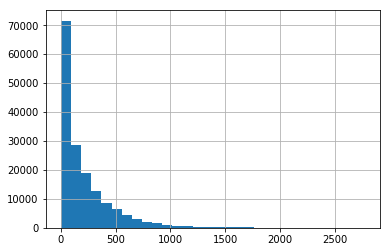

In [129]:
data[(data['ENTRIES_DIFF'] < 3000) & (data['ENTRIES_DIFF'] > 0)]['ENTRIES_DIFF'].hist(bins=30)

In [138]:
filtered_data = data[(data['ENTRIES_DIFF'] < 10000) & (data['ENTRIES_DIFF'] > 0)]

In [139]:
filtered_data.sort_values(by=['ENTRIES_DIFF'], ascending=False).head(10)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,ENTRIES_DIFF,EXITS_DIFF
4754,A033,R170,02-00-05,14 ST-UNION SQ,LNQR456W,BMT,06/19/2018,21:00:00,REGULAR,14533332,5823738,4398.0,547.0
4713,A033,R170,02-00-04,14 ST-UNION SQ,LNQR456W,BMT,06/19/2018,21:00:00,REGULAR,4100600,3123084,3857.0,1146.0
152002,R238,R046,00-03-04,GRD CNTRL-42 ST,4567S,IRT,06/20/2018,20:00:00,REGULAR,35275593,8586547,3375.0,37.0
151918,R238,R046,00-03-02,GRD CNTRL-42 ST,4567S,IRT,06/20/2018,20:00:00,REGULAR,2108944,706946,3253.0,188.0
151960,R238,R046,00-03-03,GRD CNTRL-42 ST,4567S,IRT,06/20/2018,20:00:00,REGULAR,4183730,1688193,3015.0,110.0
4672,A033,R170,02-00-03,14 ST-UNION SQ,LNQR456W,BMT,06/19/2018,21:00:00,REGULAR,5451550,6374669,2777.0,1699.0
5062,A034,R170,03-03-02,14 ST-UNION SQ,LNQR456W,BMT,06/16/2018,21:00:00,REGULAR,10569810,1156951,2724.0,337.0
4766,A033,R170,02-00-05,14 ST-UNION SQ,LNQR456W,BMT,06/21/2018,21:00:00,REGULAR,14547170,5828854,2720.0,228.0
153010,R240,R047,00-03-08,GRD CNTRL-42 ST,4567S,IRT,06/20/2018,21:00:00,REGULAR,36693767,8066656,2705.0,48.0
176510,R512,R092,00-03-00,BROADWAY,NQW,BMT,06/19/2018,12:00:00,REGULAR,37439556,3867610,2695.0,111.0


In [37]:
turnstile_data_06302018.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196690 entries, 0 to 196689
Data columns (total 11 columns):
C/A                                                                     196690 non-null object
UNIT                                                                    196690 non-null object
SCP                                                                     196690 non-null object
STATION                                                                 196690 non-null object
LINENAME                                                                196690 non-null object
DIVISION                                                                196690 non-null object
DATE                                                                    196690 non-null object
TIME                                                                    196690 non-null object
DESC                                                                    196690 non-null object
ENTRIES                           

In [42]:
turnstile_data_06022018.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196636 entries, 0 to 196635
Data columns (total 11 columns):
C/A                                                                     196636 non-null object
UNIT                                                                    196636 non-null object
SCP                                                                     196636 non-null object
STATION                                                                 196636 non-null object
LINENAME                                                                196636 non-null object
DIVISION                                                                196636 non-null object
DATE                                                                    196636 non-null object
TIME                                                                    196636 non-null object
DESC                                                                    196636 non-null object
ENTRIES                           

In [68]:
turnstile_data_03312018.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196654 entries, 0 to 196653
Data columns (total 11 columns):
C/A                                                                     196654 non-null object
UNIT                                                                    196654 non-null object
SCP                                                                     196654 non-null object
STATION                                                                 196654 non-null object
LINENAME                                                                196654 non-null object
DIVISION                                                                196654 non-null object
DATE                                                                    196654 non-null object
TIME                                                                    196654 non-null object
DESC                                                                    196654 non-null object
ENTRIES                           

In [43]:
turnstile_data_06302018.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,00:00:00,REGULAR,6667150,2259901
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,04:00:00,REGULAR,6667173,2259909
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,08:00:00,REGULAR,6667189,2259938
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,12:00:00,REGULAR,6667305,2260006
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,16:00:00,REGULAR,6667534,2260066


In [17]:
station_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 5 columns):
Remote       768 non-null object
Booth        768 non-null object
Station      768 non-null object
Line Name    768 non-null object
Division     768 non-null object
dtypes: object(5)
memory usage: 30.1+ KB


In [19]:
station_data.head(20)

,Remote,Booth,Station,Line Name,Division
0,R001,A060,WHITEHALL ST,R1,BMT
1,R001,A058,WHITEHALL ST,R1,BMT
2,R001,R101S,SOUTH FERRY,R1,IRT
3,R002,A077,FULTON ST,ACJZ2345,BMT
4,R002,A081,FULTON ST,ACJZ2345,BMT
5,R002,A082,FULTON ST,ACJZ2345,BMT
6,R003,J025,CYPRESS HILLS,J,BMT
7,R004,J028,ELDERTS LANE,JZ,BMT
8,R005,J030,FOREST PARKWAY,J,BMT
9,R006,J031,WOODHAVEN BLVD,JZ,BMT


In [27]:
station_data['Station'].nunique()

395

In [39]:
turnstile_data_06302018['STATION'].nunique()

377

In [40]:
turnstile_data_03302019['STATION'].nunique()

377

In [44]:
turnstile_data_06022018['STATION'].nunique()

375

In [70]:
turnstile_data_03312018['STATION'].nunique()

372

In [72]:
turnstile_data_03312018.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [57]:
data = turnstile_data_06022018
data.rename(
    index=str, 
    columns={'EXITS                                                               ': 'EXITS'}, 
    inplace=True)
data.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,ENTRIES_DIFF,EXITS_DIFF
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/26/2018,00:00:00,REGULAR,6633898,2248498,NaN,NaN
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/26/2018,04:00:00,REGULAR,6633916,2248500,18.0,2.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/26/2018,08:00:00,REGULAR,6633928,2248517,12.0,17.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/26/2018,12:00:00,REGULAR,6634015,2248577,87.0,60.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/26/2018,16:00:00,REGULAR,6634173,2248610,158.0,33.0


In [81]:
data[['ENTRIES_DIFF', 'EXITS_DIFF']] = data.groupby(by='SCP')[['ENTRIES', 'EXITS']].diff()
data.head(50)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,ENTRIES_DIFF,EXITS_DIFF
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/24/2018,00:00:00,REGULAR,6559322,NaN,NaN,NaN
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/24/2018,04:00:00,REGULAR,6559322,NaN,0.0,NaN
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/24/2018,08:00:00,REGULAR,6559322,NaN,0.0,NaN
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/24/2018,12:00:00,REGULAR,6559323,NaN,1.0,NaN
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/24/2018,16:00:00,REGULAR,6559327,NaN,4.0,NaN
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/24/2018,20:00:00,REGULAR,6559341,NaN,14.0,NaN
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/25/2018,00:00:00,REGULAR,6559565,NaN,224.0,NaN
7,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/25/2018,04:00:00,REGULAR,6559565,NaN,0.0,NaN
8,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/25/2018,08:00:00,REGULAR,6559565,NaN,0.0,NaN
9,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/25/2018,12:00:00,REGULAR,6559568,NaN,3.0,NaN


In [83]:
data.sort_values(by=['ENTRIES_DIFF']).head(10)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,ENTRIES_DIFF,EXITS_DIFF
54286,N083,R138,01-03-00,W 4 ST-WASH SQ,ABCDEFM,IND,03/24/2018,01:00:00,REGULAR,13030454,NaN,-2.116978e+09,NaN
125972,R117,R343,00-00-02,FRANKLIN ST,1,IRT,03/24/2018,01:00:00,REGULAR,10412092,NaN,-2.105014e+09,NaN
51233,N069,R013,01-00-01,34 ST-PENN STA,ACE,IND,03/24/2018,00:00:00,REGULAR,6955898,NaN,-2.025779e+09,NaN
23329,C023,R213,00-00-02,BAY RIDGE AV,R,BMT,03/24/2018,00:00:00,REGULAR,6322067,NaN,-2.024045e+09,NaN
39452,J035,R008,00-00-02,111 ST,J,BMT,03/24/2018,00:00:00,REGULAR,3671627,NaN,-2.022321e+09,NaN
150063,R232,R176,02-00-00,33 ST,6,IRT,03/24/2018,01:00:00,REGULAR,2926408,NaN,-1.995385e+09,NaN
160772,R283,R221,00-00-03,167 ST,4,IRT,03/24/2018,00:00:00,REGULAR,12783999,NaN,-1.995344e+09,NaN
165635,R315,R406,01-00-02,PROSPECT AV,25,IRT,03/24/2018,01:00:00,REGULAR,135959,NaN,-1.943579e+09,NaN
33353,H028,R266,00-06-00,HALSEY ST,L,BMT,03/24/2018,00:00:00,REGULAR,466442,NaN,-1.927453e+09,NaN
106717,N605,R024,00-06-00,SUTPHIN-ARCHER,EJZ,IND,03/24/2018,00:00:00,REGULAR,4874172,NaN,-1.923880e+09,NaN


In [85]:
data.sort_values(by=['ENTRIES_DIFF'], ascending=False)[data['ENTRIES_DIFF'] < 1000000].head(10)

/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,ENTRIES_DIFF,EXITS_DIFF
111263,PTH03,R552,00-00-06,JOURNAL SQUARE,1,PTH,03/24/2018,02:04:21,REGULAR,1187787,NaN,998680.0,NaN
151239,R237,R046,01-00-05,GRD CNTRL-42 ST,4567S,IRT,03/24/2018,00:00:00,REGULAR,5533573,NaN,998222.0,NaN
46027,N044,R187,00-03-02,81 ST-MUSEUM,BC,IND,03/24/2018,01:00:00,REGULAR,3408913,NaN,997283.0,NaN
129703,R138,R293,00-03-00,34 ST-PENN STA,123ACE,IRT,03/24/2018,02:00:00,REGULAR,1005936,NaN,993553.0,NaN
156867,R249,R179,01-00-02,86 ST,456,IRT,03/24/2018,00:00:00,REGULAR,1639732,NaN,985494.0,NaN
62261,N118,R199,01-00-02,KINGSTON-THROOP,C,IND,03/24/2018,00:00:00,REGULAR,1343387,NaN,982592.0,NaN
68771,N194,R338,00-00-02,BEACH 36 ST,A,IND,03/24/2018,00:00:00,REGULAR,2084684,NaN,977629.0,NaN
6675,A043,R462,00-03-01,CANAL ST,JNQRZ6W,BMT,03/24/2018,01:00:00,REGULAR,4667463,NaN,972812.0,NaN
140548,R186,R036,00-00-02,DYCKMAN ST,1,IRT,03/24/2018,00:00:00,REGULAR,2805139,NaN,971504.0,NaN
55588,N090,R139,01-05-00,CANAL ST,ACE,IND,03/24/2018,00:00:00,REGULAR,969275,NaN,967387.0,NaN


In [87]:
data.head(50)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,ENTRIES_DIFF,EXITS_DIFF
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/24/2018,00:00:00,REGULAR,6559322,NaN,NaN,NaN
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/24/2018,04:00:00,REGULAR,6559322,NaN,0.0,NaN
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/24/2018,08:00:00,REGULAR,6559322,NaN,0.0,NaN
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/24/2018,12:00:00,REGULAR,6559323,NaN,1.0,NaN
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/24/2018,16:00:00,REGULAR,6559327,NaN,4.0,NaN
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/24/2018,20:00:00,REGULAR,6559341,NaN,14.0,NaN
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/25/2018,00:00:00,REGULAR,6559565,NaN,224.0,NaN
7,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/25/2018,04:00:00,REGULAR,6559565,NaN,0.0,NaN
8,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/25/2018,08:00:00,REGULAR,6559565,NaN,0.0,NaN
9,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/25/2018,12:00:00,REGULAR,6559568,NaN,3.0,NaN
